In [218]:
%matplotlib inline
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display


In [219]:
vector_size = 100
data = []
names = []

with open('glove.6B.%id.txt'%vector_size) as f:
    for i, line in enumerate(f):
        line = line.split()
        name = line[0]
        assert len(line) == vector_size+1
        
        if not name.isalpha() or len(name) < 3:
            continue
        
        names.append(name)
        vector = []
        
        for j in range(vector_size):
            vector.append(float(line[j+1]))
        data.append(vector)
data = np.array(data, dtype='float32')
np.save('globe_%i.npy'%vector_size, data)

In [220]:
print(len(data))

325943


In [221]:
data = np.load('globe_%i.npy'%vector_size) / 5
print(data.min(), data.max())

-0.81332 0.71500003


In [222]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(vector_size, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = self.deconv1_1(input)        
        x = self.deconv1_1_bn(x)
        x = F.relu(x)
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.deconv4(x)
        x = torch.tanh(x)
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(discriminator, self).__init__()
        self.d = d
        self.conv1_1 = nn.Conv2d(1, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(int(d/2), d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.fc1 = nn.Linear(d*4*4*4, 512)
        self.fc2 = nn.Linear(512, vector_size)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, noise_mult=4):
        
        rand = (torch.rand(*input.shape) - 0.5) * noise_mult
        input = torch.clamp(input + rand.cuda(), 0, 1)
        
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)

        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)

        x = x.view(self.d, self.d*4*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [223]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [224]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    G.eval()
    test_images = G(fixed_z, fixed_x)
    test_images = (test_images.cpu() + 1) * 0.5
    G.train()
    test_images = test_images[:100].data.view(100, 1, 32, 32)
    save_image(test_images, path, nrow=10, padding=1, pad_value=1, scale_each=True, normalize=True)
    display(Image(path))

training start!
Starting 0
[1/12] - ptime: 12.46, loss_d: 0.01086869, loss_g: 0.01083202


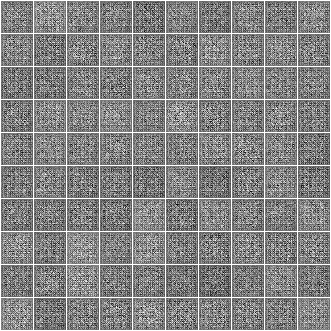

Starting 1
[2/12] - ptime: 12.46, loss_d: 0.01008249, loss_g: 0.01009155


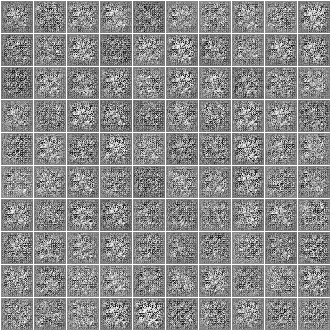

Starting 2
[3/12] - ptime: 12.48, loss_d: 0.00922100, loss_g: 0.00921498


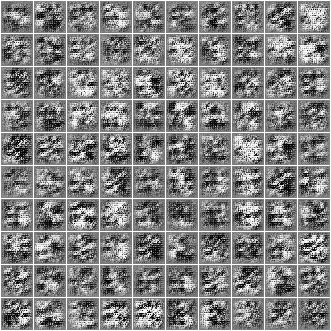

Starting 3
[4/12] - ptime: 12.47, loss_d: 0.00738925, loss_g: 0.00740313


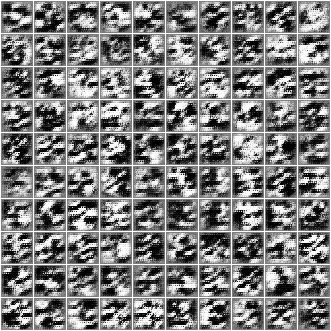

Starting 4
[5/12] - ptime: 12.45, loss_d: 0.00593328, loss_g: 0.00592473


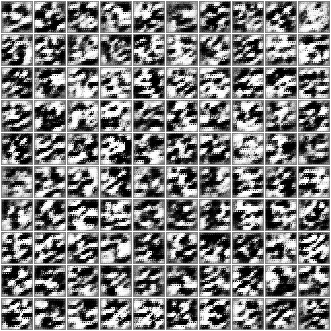

Starting 5
learning rate change!
[6/12] - ptime: 12.50, loss_d: 0.00533294, loss_g: 0.00531412


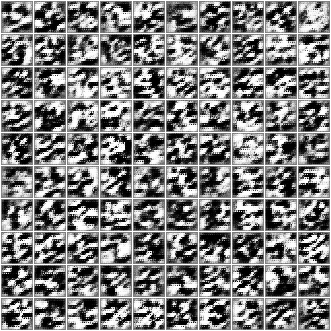

Starting 6
[7/12] - ptime: 12.52, loss_d: 0.00523369, loss_g: 0.00524561


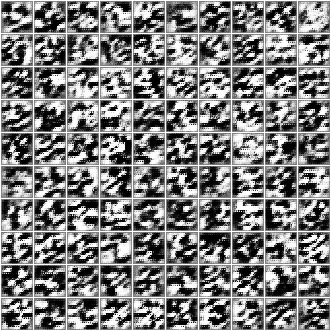

Starting 7
[8/12] - ptime: 12.53, loss_d: 0.00515896, loss_g: 0.00516021


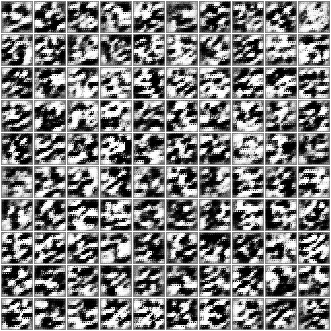

Starting 8
[9/12] - ptime: 12.55, loss_d: 0.00509555, loss_g: 0.00509756


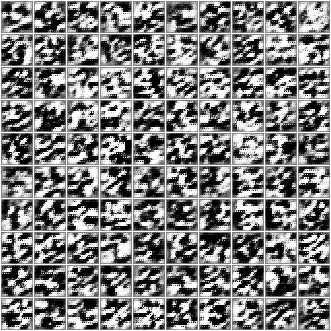

Starting 9
learning rate change!
[10/12] - ptime: 12.56, loss_d: 0.00504849, loss_g: 0.00505226


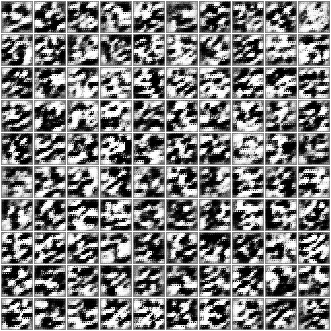

Starting 10
[11/12] - ptime: 12.56, loss_d: 0.00504294, loss_g: 0.00506179


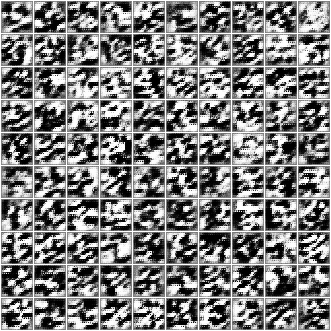

Starting 11
[12/12] - ptime: 12.56, loss_d: 0.00503278, loss_g: 0.00502660


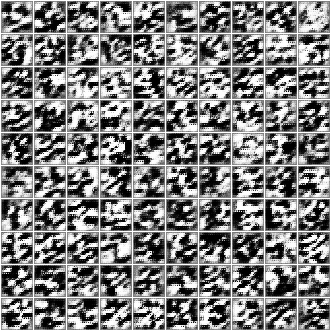

Avg one epoch ptime: 12.51, total 12 epochs ptime: 150.75
Training finish!... save training results


In [236]:
# training parameters
batch_size = 128
lr = 0.0002 * .1
train_epoch = 12

# fixed noise & label
n_samples = 100
img_per_sample = 1

top_n = 10000

n_imgs = n_samples * img_per_sample

# Todo: refactor this madness
fixed_z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

a = np.random.randint(top_n, size=(batch_size))
fixed_x = torch.from_numpy(data[a])
fixed_x.unsqueeze_(2)
fixed_x.unsqueeze_(3)
fixed_x = fixed_x.cuda()

# network
G = generator(128, vector_size=vector_size)
D = discriminator(128, vector_size=vector_size)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

MSE_loss = nn.MSELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = 'w2v_results/'
model = 'w2v_cGAN_'

if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []


print('training start!')
start_time = time.time()

for epoch in range(train_epoch):
    print('Starting', epoch)
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) in [6, 10, 14]:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    
    for i in range(400):
        a = np.random.randint(top_n, size=(batch_size))
        x = torch.from_numpy(data[a])
        x.unsqueeze_(2)
        x.unsqueeze_(3)
        x = x.cuda()

        # train discriminator D
        D.zero_grad()
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

        G_result = G(z, x)
        D_result = D(G_result)
        
        D_loss = MSE_loss(D_result.squeeze(), x.squeeze())
        D_loss.backward()
        D_optimizer.step()
        D_losses.append(D_loss.item())
        
        ################################################################################################
        # train generator G
        G.zero_grad()
        a = np.random.randint(top_n, size=(batch_size))
        x = torch.from_numpy(data[a])
        x.unsqueeze_(2)
        x.unsqueeze_(3)
        x = x.cuda()
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
    
        # Fake data loss.
        G_result = G(z, x)
        D_result = D(G_result).squeeze()

        G_train_loss = MSE_loss(D_result, x.squeeze())
        
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.8f, loss_g: %.8f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), show=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

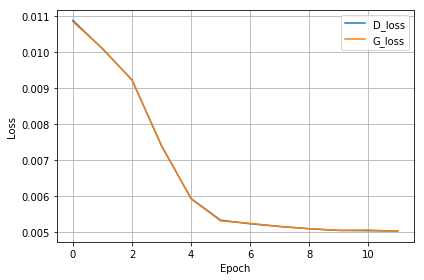

In [240]:
show_train_hist(train_hist, show=True, path=root + model + 'train_hist.png')

In [265]:
a = np.random.randint(top_n, size=(batch_size))
x = torch.from_numpy(data[a])
x.unsqueeze_(2)
x.unsqueeze_(3)
x = x.cuda()
G_result = G(fixed_z, x)
D_result = D(G_result,0)

In [266]:
def closest_word(vector_a):
    min_d = None
    min_i = None
    
    for i, vector_b in enumerate(data[:top_n]):        
        dist = np.linalg.norm(vector_a - vector_b)
        if min_d is None or dist < min_d:
            min_i = i
            min_d = dist
            
    return names[min_i] 

In [267]:
for i, index in enumerate(a):
    result_array = D_result[i].detach().cpu().numpy()
    print(names[index], closest_word(result_array))
#     print()

springfield richmond
maiden maiden
champagne champagne
battered battered
tongue tongue
circle circle
legally permitted
publishers publishers
musician musician
rare rare
capturing capturing
poorly poorly
monitoring monitoring
peruvian peruvian
forests forests
simply simply
awful awful
observed observed
aware aware
sprint competitor
fixing fixing
launch launch
magazine magazine
methods methods
satellite satellite
displaced displaced
moments moments
syndicate conjunction
practiced likewise
facts facts
nebraska nebraska
manor manor
lengthy lengthy
compiled compiled
mosul mosul
overall overall
dos likewise
pork chicken
vowed vowed
clashed clashed
blackburn blackburn
khan pakistani
liberal conservative
operators operators
pockets pockets
week week
writings writings
verse describes
fitzgerald bennett
poised poised
dust dust
die dying
affair affair
guns guns
faster faster
dubai dubai
forwards forwards
page page
carbon carbon
sacks sacks
von otto
battalion command
musharraf musharraf
singled he

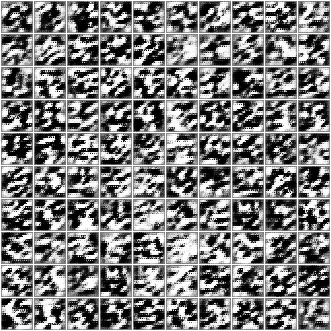

In [268]:
test_images = (G_result.cpu() + 1) * 0.5
test_images = test_images[:100].data.view(100, 1, 32, 32)
# test_images = 1 - test_images
save_image(test_images, './test.png', nrow=10, padding=1, pad_value=1, scale_each=True, normalize=True)
display(Image('./test.png'))

In [246]:
names.index('queen')

1888